# **Mount implementation folder in google drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/FYP/Implementation/models
! ls

/content/drive/MyDrive/FYP/Implementation/models
ann_backdoors.pkl  best_logr.pkl	   knn_worms.pkl
ann_dos.pkl	   ens_logr.pkl		   RandomForrest_Analysis.pkl
ann_shellcode.pkl  knn_exploits.pkl	   RandomForrest_Fuzzer.pkl
bagging_lr.pkl	   knn_generic.pkl
bagging_svr.pkl    knn_reconnaissance.pkl


# **Load attackwise best ML models**

In [3]:
from joblib import Parallel, delayed
import joblib

%cd /content/drive/MyDrive/FYP/Implementation/models

ann_backdoors = joblib.load('ann_backdoors.pkl')
ann_dos = joblib.load('ann_dos.pkl')
ann_shellcode = joblib.load('ann_shellcode.pkl')
knn_exploits = joblib.load('knn_exploits.pkl')
knn_generic = joblib.load('knn_generic.pkl')
knn_reconnaissance = joblib.load('knn_reconnaissance.pkl')
knn_worms = joblib.load('knn_worms.pkl')
RandomForrest_Analysis = joblib.load('RandomForrest_Analysis.pkl')
RandomForrest_Fuzzer = joblib.load('RandomForrest_Fuzzer.pkl')

models = [RandomForrest_Analysis, ann_backdoors, ann_dos, knn_exploits, RandomForrest_Fuzzer, knn_generic, knn_reconnaissance, ann_shellcode, knn_worms]

/content/drive/MyDrive/FYP/Implementation/models


In [4]:
%cd ../data
! ls

/content/drive/MyDrive/FYP/Implementation/data
encoded-data.csv	 preprosessing-dos.csv	       UNSW-NB15_1.csv
high_level_features.csv  selected_columns_all.csv      UNSW-NB15_2.csv
NUSW-NB15_features.csv	 SVR-predict-data.csv	       UNSW-NB15_3.csv
OTset.csv		 test_high_level_features.csv  UNSW-NB15_4.csv
preprocessing.csv	 testset.csv


## **Load training dataset**

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

attack_types = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms']
attack_labels = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] + ['attack_cat','Label']

#get selected columns for training
%cd /content/drive/MyDrive/FYP/Implementation/data
select_col=pd.read_csv("selected_columns_all.csv", sep=',', on_bad_lines='skip', index_col=False)

columns = set(['Label'])
for attack_type in attack_types:
  tmp = set(select_col[attack_type])
  columns = columns.union(tmp)

#create training dataset 
df = pd.read_csv('encoded-data.csv', sep=',', on_bad_lines='skip', index_col=False)
df = df[columns]
df

/content/drive/MyDrive/FYP/Implementation/data


,dsport,sbytes,state,ackdat,proto,tcprtt,dmeansz,ct_state_ttl,dttl,Spkts,...,swin,sttl,srcip,dur,Sload,ct_dst_sport_ltm,smeansz,ct_srv_src,dbytes,ct_src_ ltm
0,83,146,2,0.000000,120,0.000000,89,0,29,2,...,0,31,34,0.001089,5.362718e+05,1,73,4,178,1
1,83,146,2,0.000000,120,0.000000,89,0,29,2,...,0,31,36,0.001036,5.637066e+05,2,73,2,178,4
2,34,24344,5,0.000131,114,0.000656,125,0,29,230,...,255,31,41,0.988841,1.961003e+05,1,106,1,29348,8
3,83,264,6,0.000000,120,0.000000,0,0,0,2,...,0,60,10,0.000003,3.520000e+08,18,132,35,0,18
4,20880,1064,5,0.000137,114,0.000722,188,0,29,12,...,255,31,34,0.004009,1.947618e+06,1,89,12,2260,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524019,83,264,6,0.000000,120,0.000000,0,0,0,2,...,0,60,14,0.000009,1.173333e+08,23,132,23,0,23
1524020,20880,2054,5,0.000176,114,0.000801,103,0,29,22,...,255,31,34,0.426193,3.680961e+04,1,93,6,2478,1
1524021,1093,1058,5,0.066741,114,0.133565,96,1,252,12,...,255,254,31,0.667889,1.161870e+04,1,88,2,766,1
1524022,144648,3302,5,0.000256,114,0.000797,664,0,29,54,...,255,31,41,0.041776,6.206434e+05,1,61,6,37162,2


##**ANN model**

In [6]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import joblib
from sklearn.neural_network import MLPClassifier

%cd /content/drive/MyDrive/FYP/Implementation/data
high_level_features=pd.read_csv("high_level_features.csv", sep=',', on_bad_lines='skip', index_col=False)
x= np.array(high_level_features.drop(labels=['Label'], axis=1))
y = np.array(high_level_features['Label'])
print(x.shape,y.shape)
#Initializing the MLPClassifier
MLPClassifier = MLPClassifier(hidden_layer_sizes=(30, 20, 10, 5, 2), max_iter=300,activation = 'relu',solver='adam',random_state=1, verbose = 0)
#Fitting the training data to the network
clf = MLPClassifier.fit(x, y)

# Save the model as a pickle in a file
%cd /content/drive/MyDrive/FYP/Implementation/models
joblib.dump(clf, 'ann_online.pkl')


/content/drive/MyDrive/FYP/Implementation/data
(1524024, 9) (1524024,)
/content/drive/MyDrive/FYP/Implementation/models


['ann_online.pkl']

## **Computing optimal threshold**

/content/drive/MyDrive/FYP/Implementation/models
maximum_train_f1_score: 0.9562836299147538, accuracy: 0.9886130402145898, optimal_threshold:  0.450000


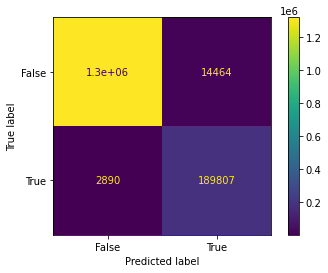

In [7]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import joblib

%cd /content/drive/MyDrive/FYP/Implementation/models
# Load the model from the file
logr = joblib.load('ann_online.pkl')

#getting probabilities of class 1
prob=logr.predict_proba(x)
prob=prob[:,1]

optimal_threshold = 0
maximum_f1 = 0

for i in range(1,100):
  threshold = i/100
  y_predict_class_train = [1 if p > threshold else 0 for p in prob]
  f1 = f1_score(y, y_predict_class_train)
  if maximum_f1 < f1:
    maximum_f1 = f1
    optimal_threshold = threshold
    opt_y_train = y_predict_class_train 

accuracy = accuracy_score(y, opt_y_train)
print(f"maximum_train_f1_score: {maximum_f1}, accuracy: {accuracy}, optimal_threshold: {optimal_threshold: .6f}")
confusion_matrix = metrics.confusion_matrix(y, opt_y_train)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

# **Test Set Results**

/content/drive/MyDrive/FYP/Implementation/data
/content/drive/MyDrive/FYP/Implementation/models
maximum_test_f1_score: 0.5549900086717189, accuracy: 0.8838301122427688, optimal_threshold:  0.450000


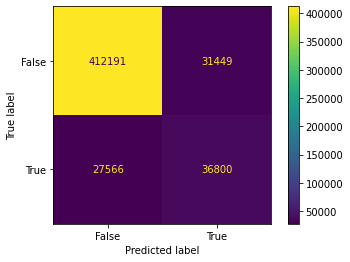

In [9]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import joblib


%cd /content/drive/MyDrive/FYP/Implementation/data
test_high_level_features=pd.read_csv("test_high_level_features.csv", sep=',', on_bad_lines='skip', index_col=False)


test_high_level_features.dropna()

#delete raws with missing values
for i in test_high_level_features.columns.values.tolist():
  i = test_high_level_features.loc[test_high_level_features[i].isnull()].index
  test_high_level_features = test_high_level_features.drop(index=list(i))
  
x_test= np.array(test_high_level_features.drop(labels=['Label'], axis=1))
y_test = np.array(test_high_level_features['Label'])

%cd /content/drive/MyDrive/FYP/Implementation/models
# Load the model from the file
logr = joblib.load('ann_online.pkl')

#getting probabilities of class 1
prob=logr.predict_proba(x_test)
prob=prob[:,1]

optimal_threshold = 0
maximum_f1 = 0

for i in range(1,100):
  threshold = i/100
  y_predict_class_train = [1 if p > threshold else 0 for p in prob]
  f1 = f1_score(y_test, y_predict_class_train)
  if maximum_f1 < f1:
    maximum_f1 = f1
    optimal_threshold = threshold
    opt_y_train = y_predict_class_train

accuracy = accuracy_score(y_test, opt_y_train)
print(f"maximum_test_f1_score: {maximum_f1}, accuracy: {accuracy}, optimal_threshold: {optimal_threshold: .6f}")
confusion_matrix = metrics.confusion_matrix(y_test, opt_y_train)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [16]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import joblib
from sklearn.neural_network import MLPClassifier

%cd /content/drive/MyDrive/FYP/Implementation/data
high_level_features=pd.read_csv("high_level_features.csv", sep=',', on_bad_lines='skip', index_col=False)
x= np.array(high_level_features.drop(labels=['Label'], axis=1))
y = np.array(high_level_features['Label'])
print(x.shape,y.shape)
#Initializing the MLPClassifier
MLPClassifier = MLPClassifier(hidden_layer_sizes=(20, 10, 5, 2), max_iter=300,activation = 'relu',solver='adam',random_state=1, verbose = 0)
#Fitting the training data to the network
clf = MLPClassifier.fit(x, y)

# Save the model as a pickle in a file
%cd /content/drive/MyDrive/FYP/Implementation/models
joblib.dump(clf, 'ann_online_2nd.pkl')


/content/drive/MyDrive/FYP/Implementation/data
(1524024, 9) (1524024,)
/content/drive/MyDrive/FYP/Implementation/models


['ann_online_2nd.pkl']

/content/drive/MyDrive/FYP/Implementation/models
maximum_train_f1_score: 0.956131961502839, accuracy: 0.9885631722335081, optimal_threshold:  0.530000


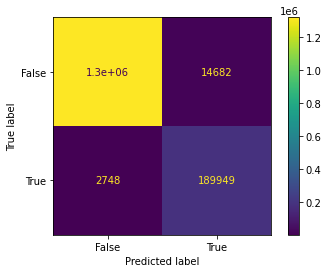

In [17]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import joblib

%cd /content/drive/MyDrive/FYP/Implementation/models
# Load the model from the file
logr = joblib.load('ann_online_2nd.pkl')

#getting probabilities of class 1
prob=logr.predict_proba(x)
prob=prob[:,1]

optimal_threshold = 0
maximum_f1 = 0

for i in range(1,100):
  threshold = i/100
  y_predict_class_train = [1 if p > threshold else 0 for p in prob]
  f1 = f1_score(y, y_predict_class_train)
  if maximum_f1 < f1:
    maximum_f1 = f1
    optimal_threshold = threshold
    opt_y_train = y_predict_class_train 

accuracy = accuracy_score(y, opt_y_train)
print(f"maximum_train_f1_score: {maximum_f1}, accuracy: {accuracy}, optimal_threshold: {optimal_threshold: .6f}")
confusion_matrix = metrics.confusion_matrix(y, opt_y_train)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

/content/drive/MyDrive/FYP/Implementation/data
/content/drive/MyDrive/FYP/Implementation/models
maximum_test_f1_score: 0.5549770428832937, accuracy: 0.8832336625945363, optimal_threshold:  0.410000


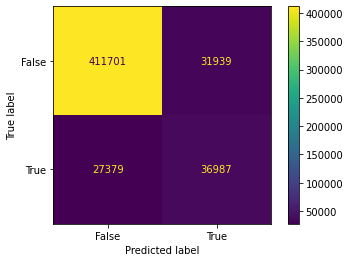

In [18]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import joblib


%cd /content/drive/MyDrive/FYP/Implementation/data
test_high_level_features=pd.read_csv("test_high_level_features.csv", sep=',', on_bad_lines='skip', index_col=False)


test_high_level_features.dropna()

#delete raws with missing values
for i in test_high_level_features.columns.values.tolist():
  i = test_high_level_features.loc[test_high_level_features[i].isnull()].index
  test_high_level_features = test_high_level_features.drop(index=list(i))
  
x_test= np.array(test_high_level_features.drop(labels=['Label'], axis=1))
y_test = np.array(test_high_level_features['Label'])

%cd /content/drive/MyDrive/FYP/Implementation/models
# Load the model from the file
logr = joblib.load('ann_online_2nd.pkl')

#getting probabilities of class 1
prob=logr.predict_proba(x_test)
prob=prob[:,1]

optimal_threshold = 0
maximum_f1 = 0

for i in range(1,100):
  threshold = i/100
  y_predict_class_train = [1 if p > threshold else 0 for p in prob]
  f1 = f1_score(y_test, y_predict_class_train)
  if maximum_f1 < f1:
    maximum_f1 = f1
    optimal_threshold = threshold
    opt_y_train = y_predict_class_train

accuracy = accuracy_score(y_test, opt_y_train)
print(f"maximum_test_f1_score: {maximum_f1}, accuracy: {accuracy}, optimal_threshold: {optimal_threshold: .6f}")
confusion_matrix = metrics.confusion_matrix(y_test, opt_y_train)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()